## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import librosa
from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

In [26]:
import denoiser
print(dir(denoiser))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [25]:
from denoiser import Denoiser

ImportError: cannot import name 'Denoiser' from 'denoiser' (/root/miniconda3/lib/python3.8/site-packages/denoiser/__init__.py)

In [8]:
'''
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
'''

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', interpolation='none')
    plt.show()

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 20500

#### Load model from checkpoint

In [61]:
!nvidia-smi


Thu Jun 20 21:27:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:13:00.0 Off |                  Off |
| 30%   46C    P2             130W / 450W |  24200MiB / 24564MiB |     58%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [18]:
#my_checkpoint_path = "outdir-16e-32b/checkpoint_100"
my_checkpoint_path = "outdir-375epoch-32batch/checkpoint_3000"
my_model = load_model(hparams)
my_model.load_state_dict(torch.load(my_checkpoint_path)['state_dict'])
my_ = my_model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [34]:
import sys
sys.path.append('/root/autodl-tmp/tacotron2'+'/waveglow') #where path_base is the path untill main folder

def load_waveglow(waveglow_path):
    waveglow = torch.load(waveglow_path)['model']
    waveglow = waveglow.remove_weightnorm(waveglow)
    waveglow.cuda().eval()
    return waveglow

In [35]:
waveglow_path = 'waveglow/waveglow_256channels_universal_v5.pt'
waveglow = load_waveglow(waveglow_path)

ModuleNotFoundError: No module named 'glow'

In [36]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
#denoiser = Denoiser(waveglow)
#deno = denoiser(waveglow)

/root/miniconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  # can be deleted
/root/miniconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  # can be deleted
/root/miniconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_p

#### Prepare text input

In [19]:
text1 = "Waveglow is really awesome!"
#text = "I hope we can all be as brave as each other."
#text = "She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."  # mel看着还行
text = "If the red of the second bow falls upon the green of the first, the result is to give a bow with an abnormally wide yellow band, since red and green light when mixed form yellow."
text = "hello."
text = "My name is Zhang Liting, and I am a student majoring in Computer Science and Technology at Nankai University"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

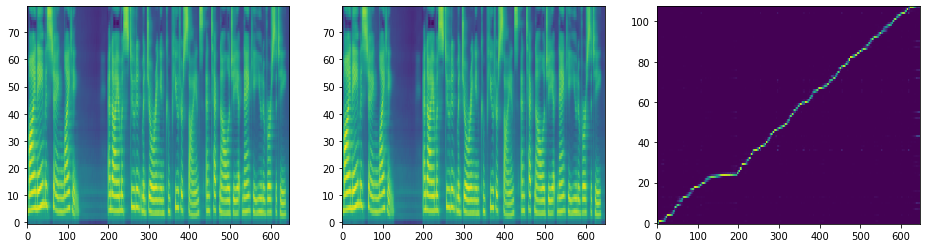

In [16]:
# 第二句话
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [77]:

print("梅尔谱大小:{}".format(mel_outputs_postnet.shape))

梅尔谱大小:torch.Size([1, 80, 900])


1表示单通道；128表示梅尔滤波器的个数；243表示时间（也就是帧数）

Warning! Reached max decoder steps


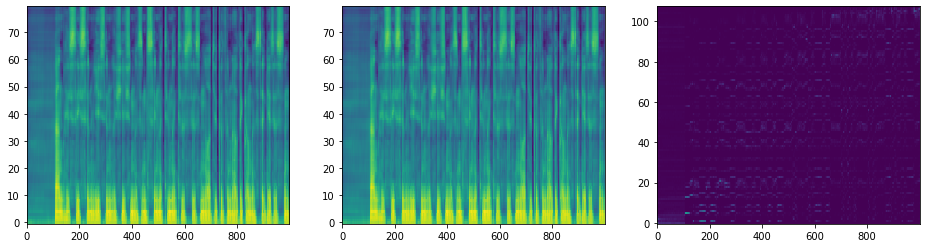

In [20]:
my_mel_outputs, my_mel_outputs_postnet, my_, my_alignments = my_model.inference(sequence)
plot_data((my_mel_outputs.float().data.cpu().numpy()[0],
           my_mel_outputs_postnet.float().data.cpu().numpy()[0],
           my_alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [40]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

RuntimeError: nvrtc: error: invalid value for --gpu-architecture (-arch)

nvrtc compilation failed: 

#define NAN __int_as_float(0x7fffffff)
#define POS_INFINITY __int_as_float(0x7f800000)
#define NEG_INFINITY __int_as_float(0xff800000)


template<typename T>
__device__ T maximum(T a, T b) {
  return isnan(a) ? a : (a > b ? a : b);
}

template<typename T>
__device__ T minimum(T a, T b) {
  return isnan(a) ? a : (a < b ? a : b);
}


#define __HALF_TO_US(var) *(reinterpret_cast<unsigned short *>(&(var)))
#define __HALF_TO_CUS(var) *(reinterpret_cast<const unsigned short *>(&(var)))
#if defined(__cplusplus)
  struct __align__(2) __half {
    __host__ __device__ __half() { }

  protected:
    unsigned short __x;
  };

  /* All intrinsic functions are only available to nvcc compilers */
  #if defined(__CUDACC__)
    /* Definitions of intrinsics */
    __device__ __half __float2half(const float f) {
      __half val;
      asm("{  cvt.rn.f16.f32 %0, %1;}\n" : "=h"(__HALF_TO_US(val)) : "f"(f));
      return val;
    }

    __device__ float __half2float(const __half h) {
      float val;
      asm("{  cvt.f32.f16 %0, %1;}\n" : "=f"(val) : "h"(__HALF_TO_CUS(h)));
      return val;
    }

  #endif /* defined(__CUDACC__) */
#endif /* defined(__cplusplus) */
#undef __HALF_TO_US
#undef __HALF_TO_CUS

typedef __half half;

extern "C" __global__
void fused_tanh_sigmoid_mul(half* tv_, half* tv__, half* aten_mul) {
{
  float v = __half2float(tv__[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)]);
  float v_1 = __half2float(tv_[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)]);
  aten_mul[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)] = __float2half((tanhf(v)) * (1.f / (1.f + (expf(0.f - v_1)))));
}
}


#### (Optional) Remove WaveGlow bias

In [9]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

waveglow安装了5个小时，但是cuda版本不匹配，放弃这个声码器

#### GL算法生成音频



In [ ]:

# mel_output 是已经计算好的Mel频谱特征
# 恢复原始音频波形
#audio = librosa.feature.inverse.mel_to_audio(mel_output)

# 保存音频文件
#librosa.output.write_wav('generated_audio.wav', audio, sr=48000)


In [ ]:
# 假设 mel_outputs_postnet 是一个在 CUDA 上的 PyTorch 张量
mel_outputs_postnet = mel_outputs_postnet.cpu()  # 将张量移动到 CPU

# 将 PyTorch 张量转换为 NumPy 数组，并且去除批次维度
spec_np = mel_outputs_postnet.squeeze().detach().numpy()

# Griffin-Lim 合成音频
reconstructed_audio = librosa.griffinlim(np.abs(spec_np))

# 保存音频文件
output_file = 'demo/gl_ta2_text2.wav'
librosa.output.write_wav(output_file, reconstructed_audio, sr=48000) 

#### wavenet

In [57]:
import torch
import torchaudio

# 加载预训练的 WaveNet 模型
wavenet = torchaudio.models.WaveNet()


OSError: libcudart.so.12: cannot open shared object file: No such file or directory

In [ ]:
# 加载已经计算好的 Mel 频谱特征，假设 mel_output 是一个 Tensor
mel_output_tensor = torch.tensor(mel_outputs_postnet)

# 生成音频波形
with torch.no_grad():
    audio = wavenet.generate(mel_output_tensor)

# 将 Tensor 转换为 NumPy 数组
audio_np = audio.numpy()

# 保存音频文件
torchaudio.save('generated_audio.wav', torch.tensor(audio_np), 48000)    # 22050)

In [3]:
import torch

# 定义保存模型的函数
def save_model_from_checkpoint(checkpoint_path, model_save_path):
    # 加载检查点
    checkpoint = torch.load(checkpoint_path)
    
    # 提取模型的状态字典
    model_state_dict = checkpoint['state_dict']
    
    # 保存模型的状态字典到新的 .pt 文件
    torch.save(model_state_dict, model_save_path)
    print(f"Model state dict saved to {model_save_path}")

# 假设你的模型类是 `Tacotron2`
class Tacotron2(torch.nn.Module):
    def __init__(self):
        super(Tacotron2, self).__init__()
        # 初始化模型结构

    def forward(self, x):
        # 定义前向传播
        pass


checkpoint_path = 'outdir-16e-32b/checkpoint_100'  
model_save_path = 'outdir-16e-32b/ftmodel_100_16e32b.pt' 

save_model_from_checkpoint(checkpoint_path, model_save_path)

# 加载并测试保存的模型（可选）
#model = Tacotron2()
#model.load_state_dict(torch.load(model_save_path))
#print("Model loaded successfully from", model_save_path)

Model state dict saved to outdir-16e-32b/ftmodel_100_16e32b.pt


In [2]:
import torch
import os

In [1]:

def save_checkpoint_as_pt(checkpoint_path, new_checkpoint_path):
    # 确保检查点文件存在
    assert os.path.isfile(checkpoint_path), "Checkpoint file not found"
    
    print("Loading checkpoint '{}'".format(checkpoint_path))
    
    # 加载检查点
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    
    # 保存检查点字典到新的 .pt 文件
    torch.save(checkpoint_dict, new_checkpoint_path)
    print(f"Checkpoint saved to {new_checkpoint_path}")

In [ ]:
checkpoint_path = 'path/to/your/checkpoint.pth'  # 检查点文件
new_checkpoint_path = 'path/to/save/your/new_checkpoint.pt' 

save_checkpoint_as_pt(checkpoint_path, new_checkpoint_path)